In [9]:
import torch
from matplotlib import pyplot as plt
from utils import *
from trainer import Trainer
from evaluator import Evaluator
from tqdm import tqdm
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset has 1635 samples


  6%|▌         | 100/1635 [02:33<32:41,  1.28s/it]

MSE for key X is: 0.10880242177472108
CRPS for key X is: 0.2078196482378987
MSE for key NIR is: 0.11671848281993458
CRPS for key NIR is: 0.2077394891720024
MSE for key IR is: 0.08104310480150943
CRPS for key IR is: 0.18955797884682077
MSE for key submm is: 0.9634739548060178
CRPS for key submm is: 0.5501830312807149


 14%|█▍        | 237/1635 [05:57<35:07,  1.51s/it]


KeyboardInterrupt: 

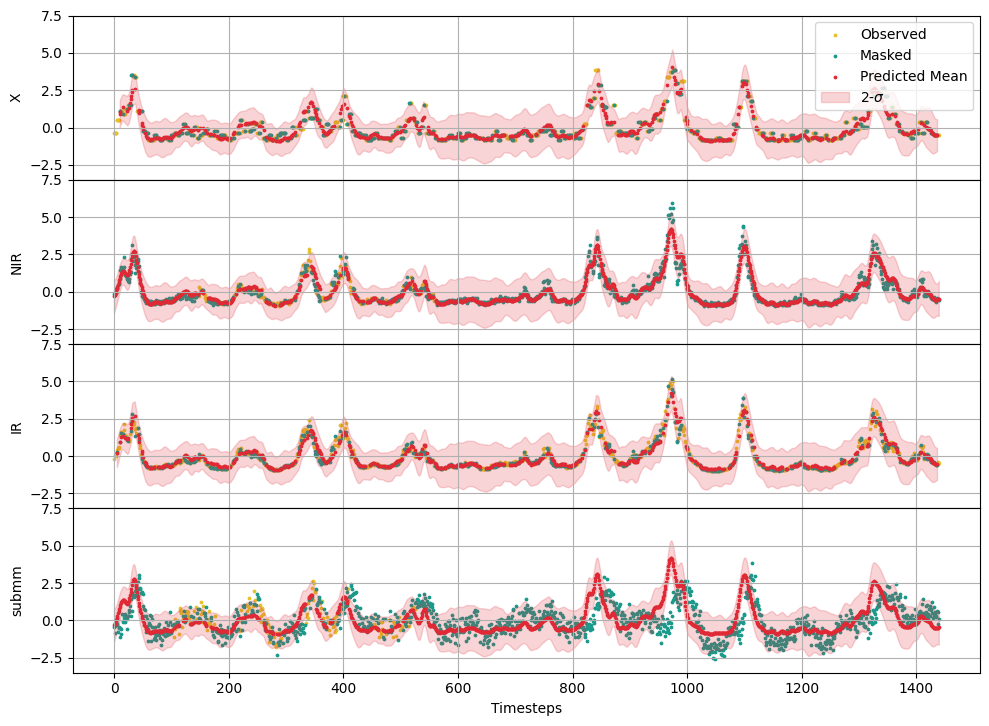

In [12]:
# Initialize a list to store the results
results = []

data = get_dataset('sgra')
keys = ["X", 'NIR', "IR", "submm"]
num_keys = len(keys)
iterations = 1000
max_early_stop = 30
plot_sample = 100

print(f'Dataset has {len(data)} samples')

for idx, sample in enumerate(tqdm(data)):
    # Process the data
    train_x, train_idx, train_y, test_x, test_y, test_idx = process_data(sample, keys)
    full_train_x = torch.cat(train_x)
    full_train_idx = torch.cat(train_idx)
    full_train_y = torch.cat(train_y)

    # Train the model
    trainer = Trainer(full_train_x, full_train_idx, full_train_y, 'gaussian', iterations=iterations, max_early_stop=max_early_stop)
    model, likelihood = trainer.train_model()

    evaluator = Evaluator(model, likelihood, test_x, test_idx, num_keys)
    observed_preds = evaluator.evaluate()

    # Initialize plots
    # if idx == plot_sample:
    #     f, axes = plt.subplots(num_keys, 1, figsize=(10, 2 * num_keys), sharex=True, gridspec_kw={'hspace': 0})
    #     if num_keys == 1:
    #         axes = [axes]

    sample_results = {"sample_index": idx}
    mse_total = 0
    crps_total = 0

    plot_data = []
    for i in range(num_keys):
        # Convert to numpy
        train_xi = train_x[i].detach().numpy()
        train_yi = train_y[i].detach().numpy()
        test_xi = test_x[i].detach().numpy()
        test_yi = test_y[i].detach().numpy()

        means = observed_preds[i].mean.cpu().detach().numpy()
        lower, upper = observed_preds[i].confidence_region()
        lower, upper = lower.detach().cpu().numpy(), upper.cpu().detach().numpy()
        standard_deviations = (upper - means) / 2.0

        # Calculate metrics
        crps = crps_norm(test_yi, means, standard_deviations)
        mse = mean_squared_error(test_yi, means)
        mse_total += mse
        crps_total += crps

        # Save metrics for the key
        sample_results[f"mse_{keys[i]}"] = mse
        sample_results[f"crps_{keys[i]}"] = crps

        if idx == plot_sample:
            tmp_dict = {'train_x': train_xi,
                        'train_y': train_yi,
                        'test_x': test_xi,
                        'test_y': test_yi,
                        'means': means,
                        'lower': lower,
                        'upper': upper}
            plot_data.append(tmp_dict)
            print(f'MSE for key {keys[i]} is: {mse}')
            print(f'CRPS for key {keys[i]} is: {crps}')


    # Save averaged metrics
    sample_results["average_mse"] = mse_total / num_keys
    sample_results["average_crps"] = crps_total / num_keys
    results.append(sample_results)

    # Save the plot
    if idx == plot_sample:
        plot_example(plot_data, keys)

# Save results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)

print("Processing complete. Results saved to 'results.csv' and plots saved to the 'plots/' directory.")


In [7]:
# Load the results.csv file
results_df = pd.read_csv("results.csv")

# Calculate mean CRPS and MSE for each key
mean_crps_per_key = results_df[[col for col in results_df.columns if col.startswith("crps_")]].mean()
mean_mse_per_key = results_df[[col for col in results_df.columns if col.startswith("mse_")]].mean()

# Calculate overall averages
overall_mean_crps = mean_crps_per_key.mean()
overall_mean_mse = mean_mse_per_key.mean()

# Display results
print("Mean CRPS per key:")
print(mean_crps_per_key)

print("\nMean MSE per key:")
print(mean_mse_per_key)

print("\nOverall Mean CRPS:", overall_mean_crps)
print("Overall Mean MSE:", overall_mean_mse)

Mean CRPS per key:
crps_X        0.228143
crps_NIR      0.196565
crps_IR       0.185430
crps_submm    0.468118
dtype: float64

Mean MSE per key:
mse_X        0.174009
mse_NIR      0.118550
mse_IR       0.100220
mse_submm    0.728887
dtype: float64

Overall Mean CRPS: 0.2695643373617112
Overall Mean MSE: 0.28041648869531005
